In [1]:
%matplotlib inline

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import math
from skimage import exposure
from geophys_utils import get_utm_wkt, get_spatial_ref_from_wkt, transform_coords
from dynamic_point_gridding_utils import get_netcdf_datasets, dataset_value_generator, grid_points # Code for this example
#from geophys_utils import array2file
#from osgeo import gdal

In [3]:
# Set up search criteria
GDA94_bounds = (119.0, -28.25, 119.75, -27.5) # Bounding box in GDA94 coordinates
keywords = 'point, gravity, point located data, ground digital data, geophysical survey' # Comma-separated list of keywords
grid_variable_name = 'bouguer'

In [4]:
# Calculate extra spatial information about area of interest, including LL, UR points in UTM
GDA94_wkt = get_spatial_ref_from_wkt('EPSG:4283').ExportToWkt()
print(GDA94_wkt)

GDA94_centre_coords = [(GDA94_bounds[dim_index] + GDA94_bounds[dim_index+2]) / 2.0 for dim_index in range(2)]
print(GDA94_centre_coords)

utm_wkt = get_utm_wkt(GDA94_centre_coords, GDA94_wkt)
print(utm_wkt)

print(GDA94_bounds)
GDA94_bounding_box = ((GDA94_bounds[0], GDA94_bounds[1]), 
                                                      (GDA94_bounds[2], GDA94_bounds[1]), 
                                                      (GDA94_bounds[2], GDA94_bounds[3]), 
                                                      (GDA94_bounds[0], GDA94_bounds[3])
                                                      )
print(GDA94_bounding_box)

reprojected_bounding_box = np.array(transform_coords(GDA94_bounding_box, 
                                                     GDA94_wkt, utm_wkt))
print(reprojected_bounding_box)

utm_bounds = [min(reprojected_bounding_box[:,0]), 
              min(reprojected_bounding_box[:,1]), 
              max(reprojected_bounding_box[:,0]), 
              max(reprojected_bounding_box[:,1])]
print(utm_bounds)

# Expand GDA94 bounding box for point data retrieval to try to ensure complete coverage of UTM bounds

EXTRA=2000 # Extra distance to extend bounds for point data retrieval on each side
expanded_utm_bounding_box = ((utm_bounds[0]-EXTRA, utm_bounds[1]-EXTRA), 
                    (utm_bounds[2]+EXTRA, utm_bounds[1]-EXTRA), 
                    (utm_bounds[2]+EXTRA, utm_bounds[3]+EXTRA), 
                    (utm_bounds[0]-EXTRA, utm_bounds[3]+EXTRA)
                    )
print(expanded_utm_bounding_box)

reprojected_bounding_box = np.array(transform_coords(expanded_utm_bounding_box, 
                                                     utm_wkt, GDA94_wkt))

expanded_GDA94_bounds = [min(reprojected_bounding_box[:,0]), 
              min(reprojected_bounding_box[:,1]), 
              max(reprojected_bounding_box[:,0]), 
              max(reprojected_bounding_box[:,1])]
print(expanded_GDA94_bounds)

GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]]
[119.375, -27.875]
PROJCS["UTM Zone 50, Southern Hemisphere",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["Meter",1]]
(119.0, -28.25, 119.75, -27.5)
((119.0, -28.25), (119.75, -28.25), (119.75, -27.5), (119.0, -27.5))
[[ 696211.49313013 6873482.01852291]
 [ 769817.92972

In [5]:
# Find all NetCDF paths using CSW
netcdf_list = sorted(get_netcdf_datasets(keywords, 
                                         bounding_box=expanded_GDA94_bounds))
print('\n'.join(netcdf_list))
assert len(netcdf_list), 'No datasets found'

Querying CSW
24 matching dataset records found from CSW
24 NetCDF distributions found
http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/Commonwealth/P195099/points/P195099_GNDGRAV/P195099_GNDGRAV.nc
http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/Commonwealth/P196091/points/P196091_GNDGRAV/P196091_GNDGRAV.nc
http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/Commonwealth/P196491/points/P196491_GNDGRAV/P196491_GNDGRAV.nc
http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/Commonwealth/P196500/points/P196500_GNDGRAV/P196500_GNDGRAV.nc
http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/Commonwealth/P196792/points/P196792_GNDGRAV/P196792_GNDGRAV.nc
http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/Commonwealth/P196793/points/P196793_GNDGRAV/P196793_GNDGRAV.nc
http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/Commonwealth/P198090/points/P198090_GNDGRAV/P198090_GNDGRAV.nc
http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/C

In [6]:
# Retrieve all points in bounding box from NetCDF files in UTM projection
# N.B: This may take some time depending on the size of the bounds and the number and size of line datasets
# Lines will be filtered to exclude tielines by using "flight_lines_only=True"
dataset_values = {dataset: dataset_value_dict
                  for dataset, dataset_value_dict in dataset_value_generator([grid_variable_name, 'gridflag'],
                                                              netcdf_list, 
                                                              expanded_GDA94_bounds,
                                                              )
                 }

#print(dataset_values)

0/57 points found in bounding box for http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/Commonwealth/P195099/points/P195099_GNDGRAV/P195099_GNDGRAV.nc
0/17 points found in bounding box for http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/Commonwealth/P196091/points/P196091_GNDGRAV/P196091_GNDGRAV.nc
0/268 points found in bounding box for http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/Commonwealth/P196491/points/P196491_GNDGRAV/P196491_GNDGRAV.nc
0/9 points found in bounding box for http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/Commonwealth/P196500/points/P196500_GNDGRAV/P196500_GNDGRAV.nc
3/62 points found in bounding box for http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/Commonwealth/P196792/points/P196792_GNDGRAV/P196792_GNDGRAV.nc


C:\Users\alex\Anaconda3\lib\site-packages\geophys_utils\_netcdf_point_utils.py:662: UserWarning: WARNING: _FillValue not used since it
cannot be safely cast to variable data type
  result_array = lookup_variable[:][indexing_variable[start_index:end_index][subset_mask]] # Need to index numpy array, not netCDF variable


0/36 points found in bounding box for http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/Commonwealth/P196793/points/P196793_GNDGRAV/P196793_GNDGRAV.nc
0/46 points found in bounding box for http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/Commonwealth/P198090/points/P198090_GNDGRAV/P198090_GNDGRAV.nc
0/7 points found in bounding box for http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/Commonwealth/P199191/points/P199191_GNDGRAV/P199191_GNDGRAV.nc
0/61 points found in bounding box for http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/Commonwealth/P200799/points/P200799_GNDGRAV/P200799_GNDGRAV.nc
0/11 points found in bounding box for http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/Commonwealth/P201099/points/P201099_GNDGRAV/P201099_GNDGRAV.nc
0/12 points found in bounding box for http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/Commonwealth/P201299/points/P201299_GNDGRAV/P201299_GNDGRAV.nc
0/35 points found in bounding box for htt

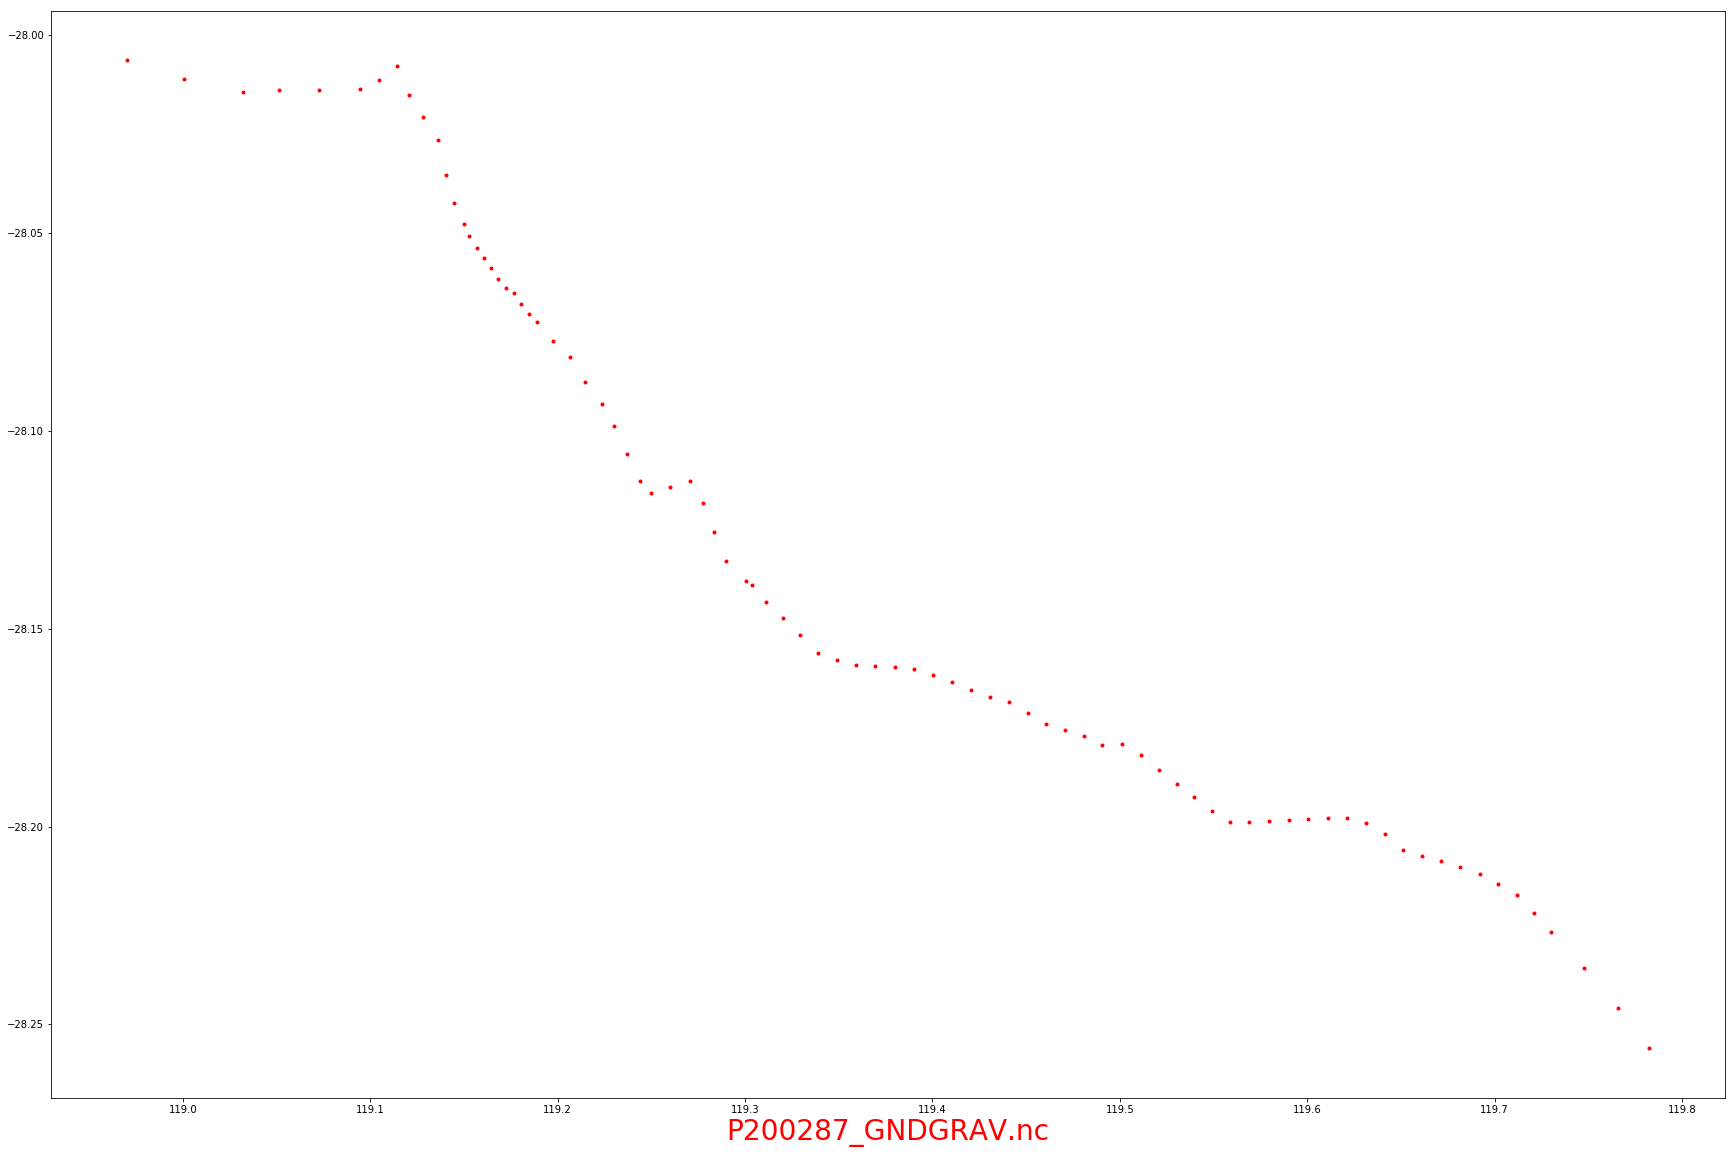

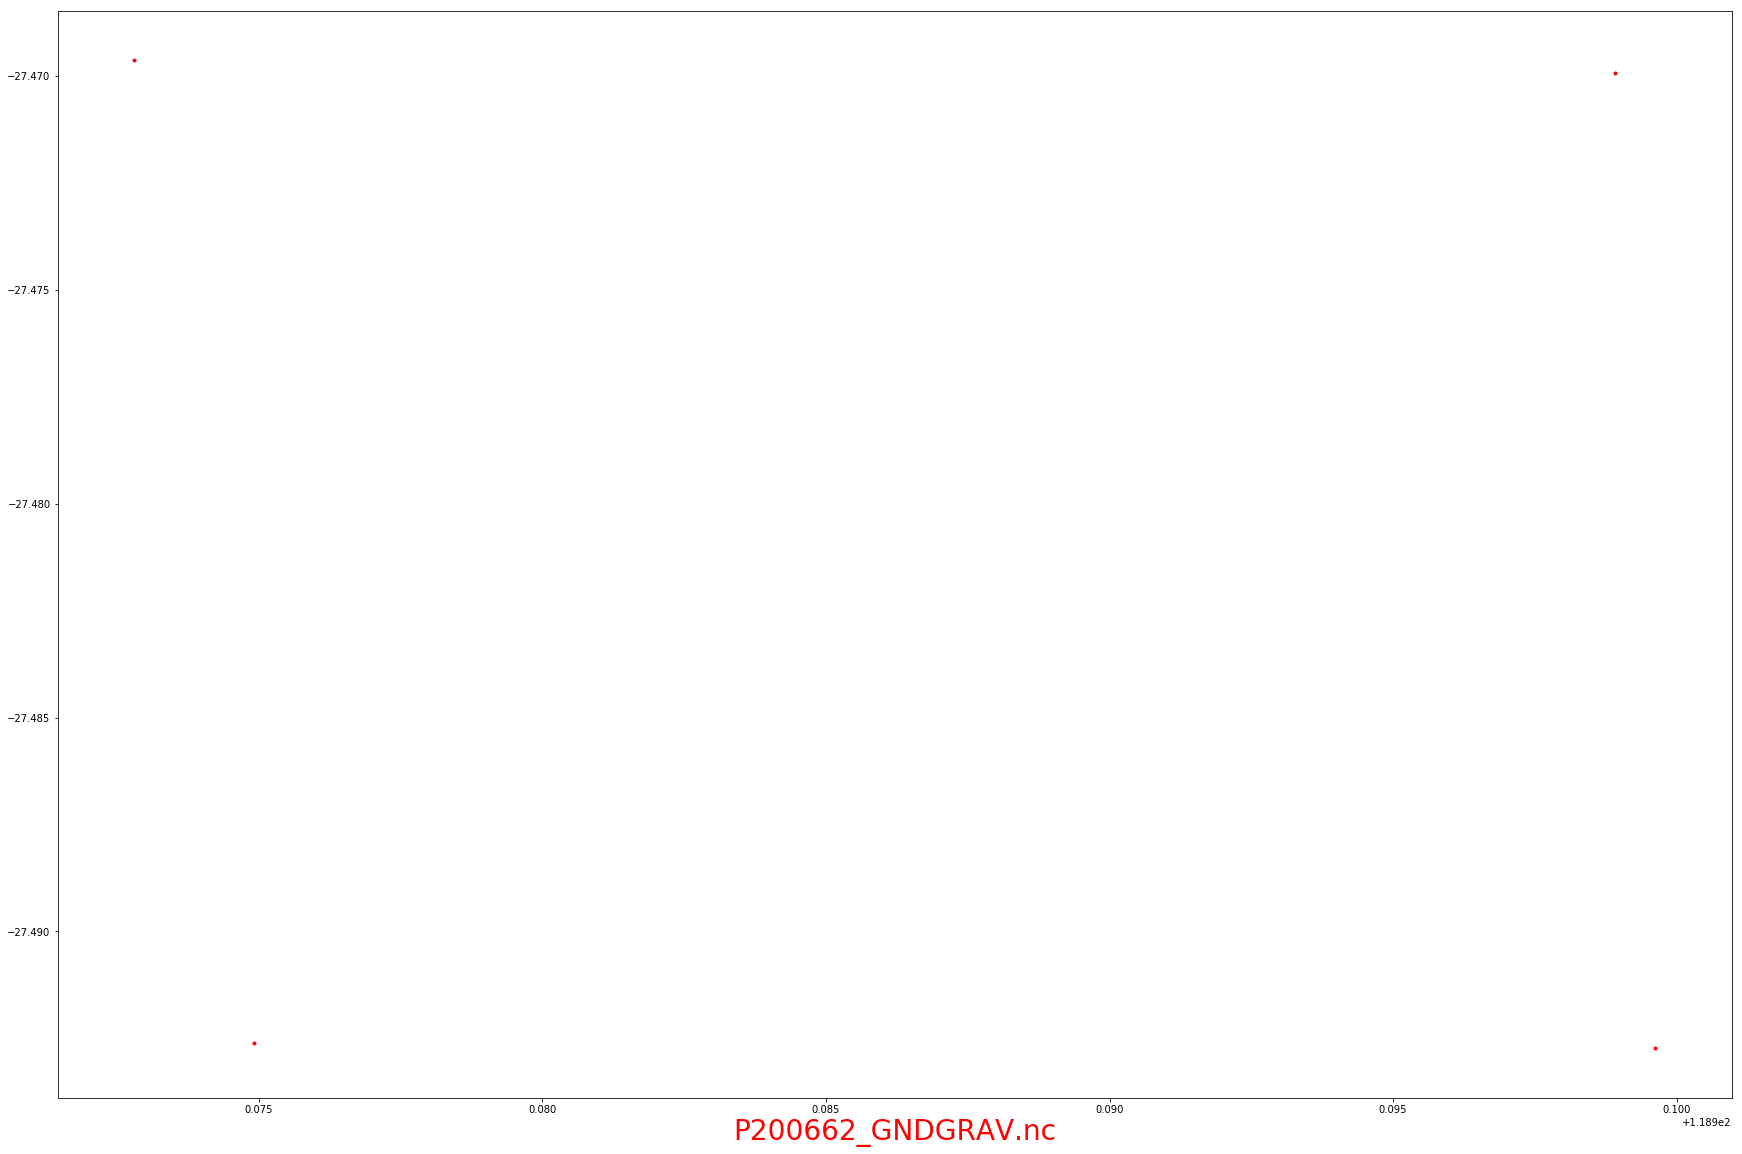

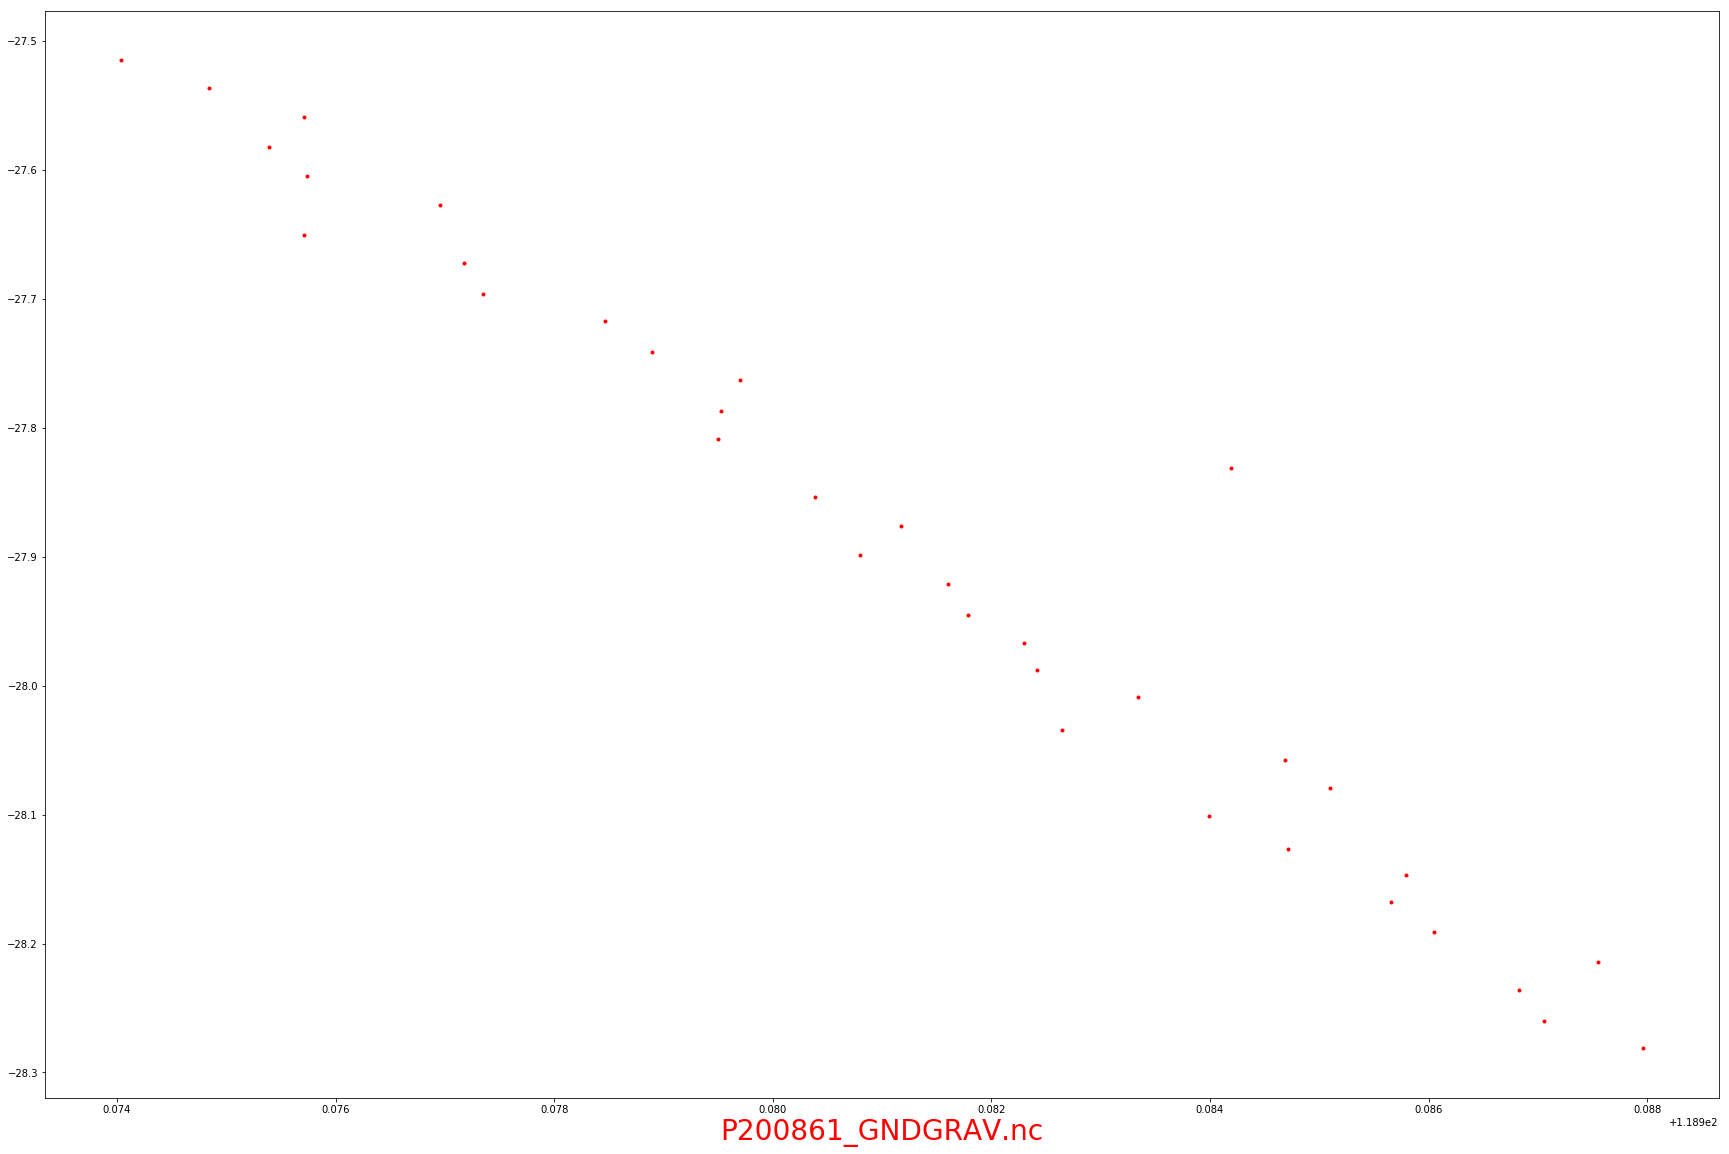

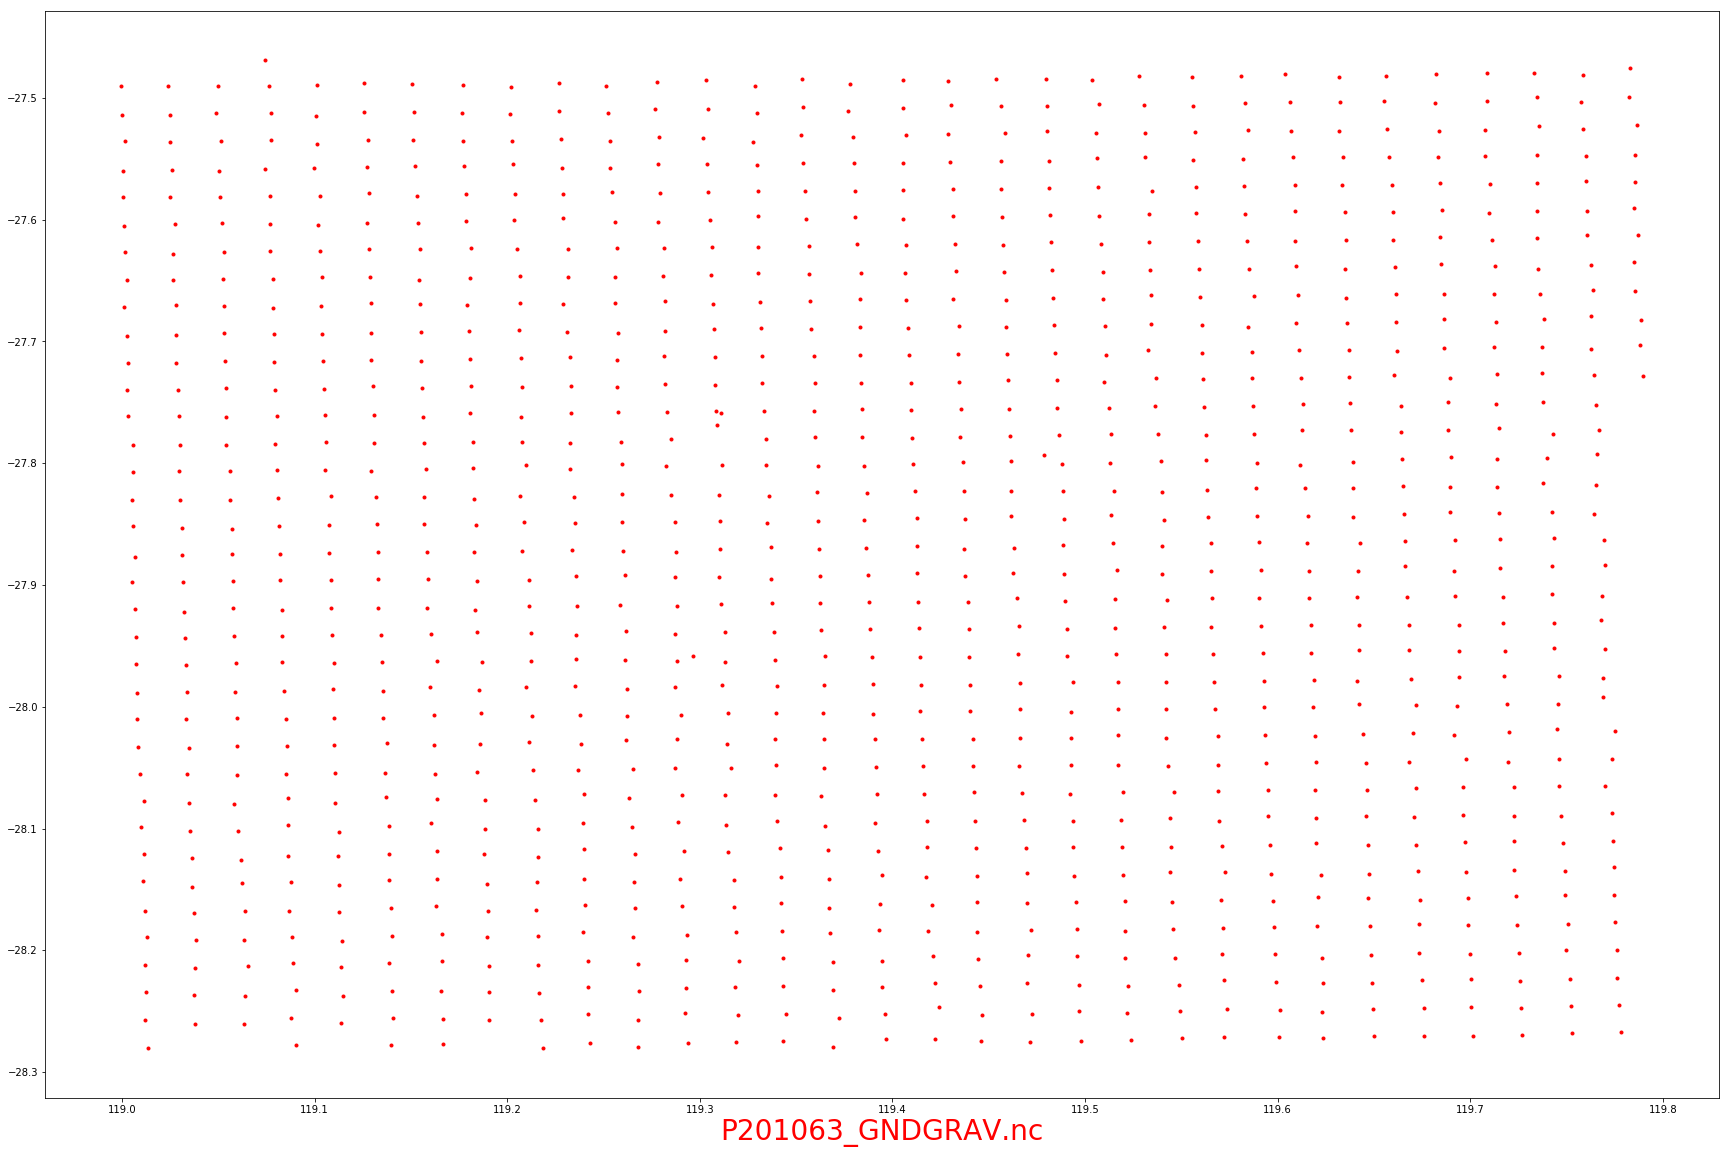

In [7]:
# Plot filtered points for the datasets
# Only show points where gridflag == 'Station used in the production of GA grids.'
for dataset in sorted(dataset_values.keys()):
    #print(dataset)
    #print(len(dataset_values[dataset]['coordinates']))
    #print(len(dataset_values[dataset]['gridflag'] == 'Station used in the production of GA grids.'))
    coordinates = dataset_values[dataset]['coordinates'][dataset_values[dataset]['gridflag'] == 'Station used in the production of GA grids.']
    if len(coordinates):
        plt.figure(figsize=(30,20))
        plt.xlabel(os.path.basename(dataset), fontsize=28, color='red')
        plt.plot(coordinates[:,0], coordinates[:,1], 'r.')

In [8]:
# Gather all filtered points in bounding box in UTM projection
# Only use points where gridflag == 'Station used in the production of GA grids.'
all_coordinates = np.concatenate([dataset_values[dataset]['coordinates'][dataset_values[dataset]['gridflag'] == 'Station used in the production of GA grids.']
                                  for dataset in sorted(dataset_values.keys())])
all_values = np.concatenate([dataset_values[dataset][grid_variable_name][dataset_values[dataset]['gridflag'] == 'Station used in the production of GA grids.']
                                  for dataset in sorted(dataset_values.keys())])
print(all_coordinates)
print(all_values)
print(len(all_values))

[[119.15028  -28.04769 ]
 [119.21439  -28.08754 ]
 [119.28988  -28.13297 ]
 ...
 [119.48145  -27.551672]
 [119.48031  -27.527407]
 [119.47955  -27.48433 ]]
[-683.5  -418.04 -514.13 ... -555.51 -529.74 -535.65]
1252


In [9]:
# Interpolate points to grid
interpolated_grid, wkt, geotransform = grid_points(coordinates=all_coordinates,
                                 coordinate_wkt=GDA94_wkt,
                                 values=all_values,
                                 grid_wkt=utm_wkt, 
                                 grid_bounds=utm_bounds,
                                 grid_resolution=100, #grid_resolution, 
                                 resampling_method='linear', 
                                 point_step=1
                                 )

Reprojecting coordinates
Generating grid coordinates
Generating point subset mask
Interpolating 1251 points
Interpolation complete


In [10]:
# Print some stats from the grid
print('Shape: ', interpolated_grid.shape)
print('Min:  ', np.nanmin(interpolated_grid))
print('Mean: ', np.nanmean(interpolated_grid))
print('Max:  ', np.nanmax(interpolated_grid))
print('geotransform: ', geotransform)
print('wkt: ', wkt)

Shape:  (846, 755)
Min:   -844.8336783913849
Mean:  -677.6467074622122
Max:   -232.45497968373496
geotransform:  [696150.0, 100, 0, 6956550.0, 0, -100]
wkt:  PROJCS["UTM Zone 50, Southern Hemisphere",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["Meter",1]]


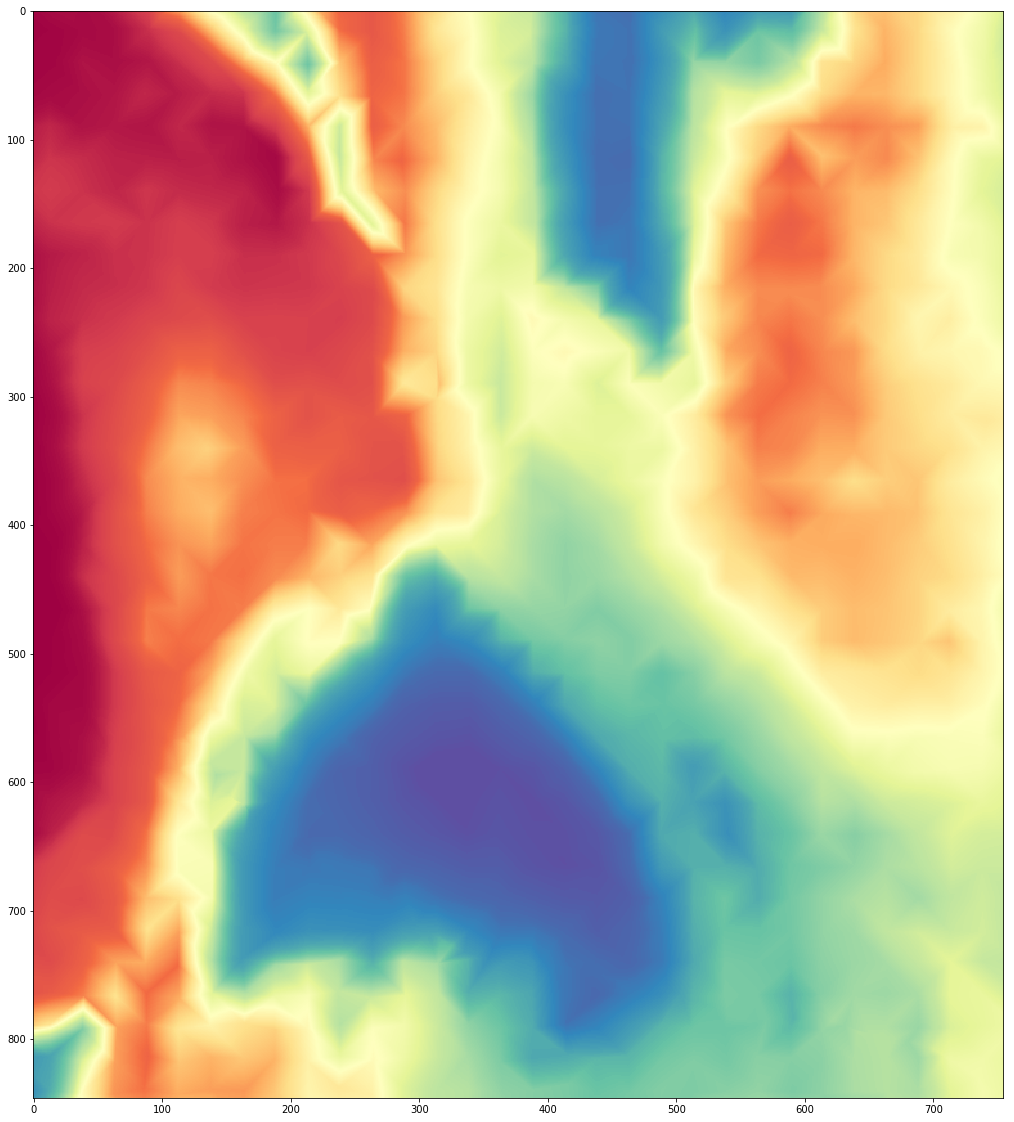

In [11]:
# Plot interpolated grid with histogram equalisation
# Substitute minimum value for NaN values
filled_grid = np.array(interpolated_grid)
filled_grid[np.isnan(filled_grid)] = np.nanmin(filled_grid)
plt.figure(figsize=(30,20))    
plt.imshow(exposure.equalize_hist(filled_grid), cmap='Spectral')